In [1]:
# importing libs
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Dense, GaussianNoise,Lambda,Dropout
from keras.models import Model
from keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from keras.optimizers import Adam,SGD
from keras import backend as K

# for reproducing reslut
from numpy.random import seed
seed(1)
import tensorflow 
tensorflow.random.set_seed(3)

In [2]:
# defining parameters
# define (n,k) here for (n,k) autoencoder
# n = n_channel 
# k = log2(M)  ==> so for (2,2) autoencoder n_channel = 2 and M = 2^2 = 4 
M = 4
k = np.log2(M)
k = int(k)
n_channel = 2
R = k/n_channel
print ('M:',M,'k:',k,'n:',n_channel)

M: 4 k: 2 n: 2


In [3]:
#generating data of size N
N = 8000
label = np.random.randint(M,size=N)
# creating one hot encoded vectors
data = []
for i in label:
    temp = np.zeros(M)
    temp[i] = 1
    data.append(temp)   

In [4]:
# checking data shape
data = np.array(data)
print (data.shape)

(8000, 4)


In [5]:
# checking generated data with it's label
temp_check = [17,23,45,67,89,96,72,250,350]
for i in temp_check:
    print(label[i],data[i])

1 [0. 1. 0. 0.]
0 [1. 0. 0. 0.]
1 [0. 1. 0. 0.]
3 [0. 0. 0. 1.]
1 [0. 1. 0. 0.]
3 [0. 0. 0. 1.]
0 [1. 0. 0. 0.]
3 [0. 0. 0. 1.]
0 [1. 0. 0. 0.]


In [6]:
# defining autoencoder and it's layer
input_signal = Input(shape=(M,))
encoded = Dense(M, activation='relu')(input_signal)
encoded1 = Dense(n_channel, activation='linear')(encoded)
encoded2 = Lambda(lambda x: np.sqrt(n_channel)*K.l2_normalize(x,axis=1))(encoded1)

EbNo_train = 5.01187 #  coverted 7 db of EbNo

In [7]:
# defining autoencoder and it's layer
input_signal = Input(shape=(M,))
encoded = Dense(M, activation='relu')(input_signal)
encoded1 = Dense(n_channel, activation='linear')(encoded)
encoded2 = Lambda(lambda x: np.sqrt(n_channel)*K.l2_normalize(x,axis=1))(encoded1)

EbNo_train = 5.01187 #  coverted 7 db of EbNo
encoded3 = GaussianNoise(np.sqrt(1/(2*R*EbNo_train)))(encoded2)

decoded = Dense(M, activation='relu')(encoded3)
decoded1 = Dense(M, activation='softmax')(decoded)
autoencoder = Model(input_signal, decoded1)
adam = Adam(lr=0.01)
autoencoder.compile(optimizer=adam, loss='categorical_crossentropy')

C:\Users\Surya\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [8]:
# printing summary of layers and it's trainable parameters 
print (autoencoder.summary())
# for tensor board visualization
#tbCallBack = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=True, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
# traning auto encoder

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 dense_3 (Dense)             (None, 2)                 10        
                                                                 
 lambda_1 (Lambda)           (None, 2)                 0         
                                                                 
 gaussian_noise (GaussianNoi  (None, 2)                0         
 se)                                                             
                                                                 
 dense_4 (Dense)             (None, 4)                 12        
                                                             

In [9]:
autoencoder.fit(data, data,
                epochs=45,
                batch_size=32)

Epoch 1/45
250/250 [==============================] - 1s 2ms/step - loss: 0.4327
Epoch 2/45
250/250 [==============================] - 1s 3ms/step - loss: 0.0368
Epoch 3/45
250/250 [==============================] - 1s 3ms/step - loss: 0.0233
Epoch 4/45
250/250 [==============================] - 1s 3ms/step - loss: 0.0154
Epoch 5/45
250/250 [==============================] - 1s 3ms/step - loss: 0.0160
Epoch 6/45
250/250 [==============================] - 1s 3ms/step - loss: 0.0142
Epoch 7/45
250/250 [==============================] - 1s 3ms/step - loss: 0.0148
Epoch 8/45
250/250 [==============================] - 1s 5ms/step - loss: 0.0097
Epoch 9/45
250/250 [==============================] - 1s 4ms/step - loss: 0.0101
Epoch 10/45
250/250 [==============================] - 1s 3ms/step - loss: 0.0074
Epoch 11/45
250/250 [==============================] - 1s 3ms/step - loss: 0.0061
Epoch 12/45
250/250 [==============================] - 1s 3ms/step - loss: 0.0079
Epoch 13/45
250/250 [====

In [10]:
# saving keras model
from keras.models import load_model
# if you want to save model then remove below comment
# autoencoder.save('autoencoder_v_best.model')
# making encoder from full autoencoder
encoder = Model(input_signal, encoded2)
# making decoder from full autoencoder
encoded_input = Input(shape=(n_channel,))

deco = autoencoder.layers[-2](encoded_input)
deco = autoencoder.layers[-1](deco)
decoder = Model(encoded_input, deco)

In [11]:
# generating data for checking BER
# if you're not using t-sne for visulation than set N to 70,000 for better result 
# for t-sne use less N like N = 1500
N = 50000
test_label = np.random.randint(M,size=N)
test_data = []

for i in test_label:
    temp = np.zeros(M)
    temp[i] = 1
    test_data.append(temp)
    
test_data = np.array(test_data)

In [12]:
# checking generated data
temp_test = 6
print (test_data[temp_test][test_label[temp_test]],test_label[temp_test])
# for plotting learned consteallation diagram

scatter_plot = []
for i in range(0,M):
    temp = np.zeros(M)
    temp[i] = 1
    scatter_plot.append(encoder.predict(np.expand_dims(temp,axis=0)))
scatter_plot = np.array(scatter_plot)
print (scatter_plot.shape)

1.0 1
1/1 [==============================] - 0s 41ms/step
(4, 1, 2)


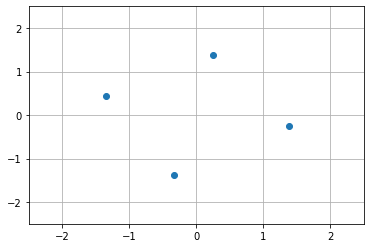

In [13]:
# ploting constellation diagram
import matplotlib.pyplot as plt
scatter_plot = scatter_plot.reshape(M,2,1)
plt.scatter(scatter_plot[:,0],scatter_plot[:,1])
plt.axis((-2.5,2.5,-2.5,2.5))
plt.grid()
plt.savefig('AutoEncoder_2_2_constillation')
plt.show()
def frange(x, y, jump):
  while x < y:
    yield x
    x += jump

In [14]:
# calculating BER
# this is optimized BER function so it can handle large number of N
# previous code has another for loop which was making it slow
EbNodB_range = list(frange(-4,8.5,0.5))
ber = [None]*len(EbNodB_range)
for n in range(0,len(EbNodB_range)):
    EbNo=10.0**(EbNodB_range[n]/10.0)
    noise_std = np.sqrt(1/(2*R*EbNo))
    noise_mean = 0
    no_errors = 0
    nn = N
    noise = noise_std * np.random.randn(nn,n_channel)
    encoded_signal = encoder.predict(test_data) 
    final_signal = encoded_signal + noise
    pred_final_signal =  decoder.predict(final_signal)
    pred_output = np.argmax(pred_final_signal,axis=1)
    no_errors = (pred_output != test_label)
    no_errors =  no_errors.astype(int).sum()
    ber[n] = no_errors / nn 
    print ('SNR:',EbNodB_range[n],'BER:',ber[n])

1563/1563 [==============================] - 5s 3ms/step
SNR: -4 BER: 0.33846
1563/1563 [==============================] - 3s 2ms/step
SNR: -3.5 BER: 0.32074
1563/1563 [==============================] - 3s 2ms/step
SNR: -3.0 BER: 0.29762
1563/1563 [==============================] - 3s 2ms/step
SNR: -2.5 BER: 0.27108
1563/1563 [==============================] - 5s 3ms/step
SNR: -2.0 BER: 0.24682
1563/1563 [==============================] - 4s 3ms/step
SNR: -1.5 BER: 0.22564
1563/1563 [==============================] - 4s 2ms/step
SNR: -1.0 BER: 0.2039
1563/1563 [==============================] - 3s 2ms/step
SNR: -0.5 BER: 0.1819
1563/1563 [==============================] - 3s 2ms/step
SNR: 0.0 BER: 0.15722
1563/1563 [==============================] - 3s 2ms/step
SNR: 0.5 BER: 0.13264
1563/1563 [==============================] - 3s 2ms/step
SNR: 1.0 BER: 0.11304
1563/1563 [==============================] - 4s 2ms/step
SNR: 1.5 BER: 0.0976
1563/1563 [==============================] - 4s 2

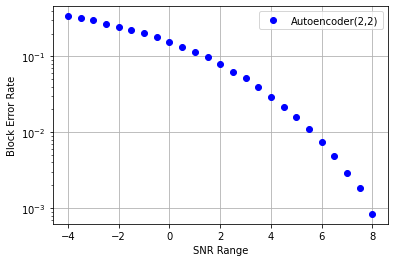

In [15]:
    # use below line for generating matlab like matrix which can be copy and paste for plotting ber graph in matlab
    #print(ber[n], " ",end='')
# ploting ber curve
import matplotlib.pyplot as plt
from scipy import interpolate
plt.plot(EbNodB_range, ber, 'bo',label='Autoencoder(2,2)')
plt.yscale('log')
plt.xlabel('SNR Range')
plt.ylabel('Block Error Rate')
plt.grid()
plt.legend(loc='upper right',ncol = 1)
# for saving figure remove below comment
plt.savefig('AutoEncoder_2_2_constrained_BER_matplotlib')
plt.show()